In [ ]:
# Imports
import importlib
import sys
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
sys.path.append('../_shared_packages')
import process_cl2_logfile as process_cl2#This underline is unavoidable
importlib.reload(process_cl2)

# Load the file... (path,exp_name,ftir_path)
info = (('data/10-10-24_count_cl_excess_ch4.csv','10-10-24 Cl* Count w/ Excess CH4',None),
        )
hush=True
raw_data = process_cl2.extract_data([i[:2] for i in info],hush)

# Rebind the ftir
ftir_fields_to_rebind = (('CH4 (PF) 191c average','FTIR: CH4 (ppm)'),('CO2 ppm 191c average','FTIR: CO2 (ppm)'),
                         ('CO ppm 191C (1of2) average','FTIR: CO (ppm)'),('Formaldehyde 191c average','FTIR: CH2O (ppm)'),)
for i in info:
    (path,exp_name,ftir_path)=i
    if ftir_path is not None:
        process_cl2.rebind_ftir_prn(raw_data[exp_name],ftir_path,ftir_fields_to_rebind,hush)

for df in raw_data.values():
    try:
        df['FTIR: CH2O (ppm)']+=0.5 #One can see on inspection that the 'baseline' CH2O value is -0.5, not 0, for some reason. We correct that.
    except: #FTIR widget not used, or said 'no reading' the whole time.
        pass

# Suppress a printout
pass

<h1> Loading, trimming, and re-binding log files </h1>

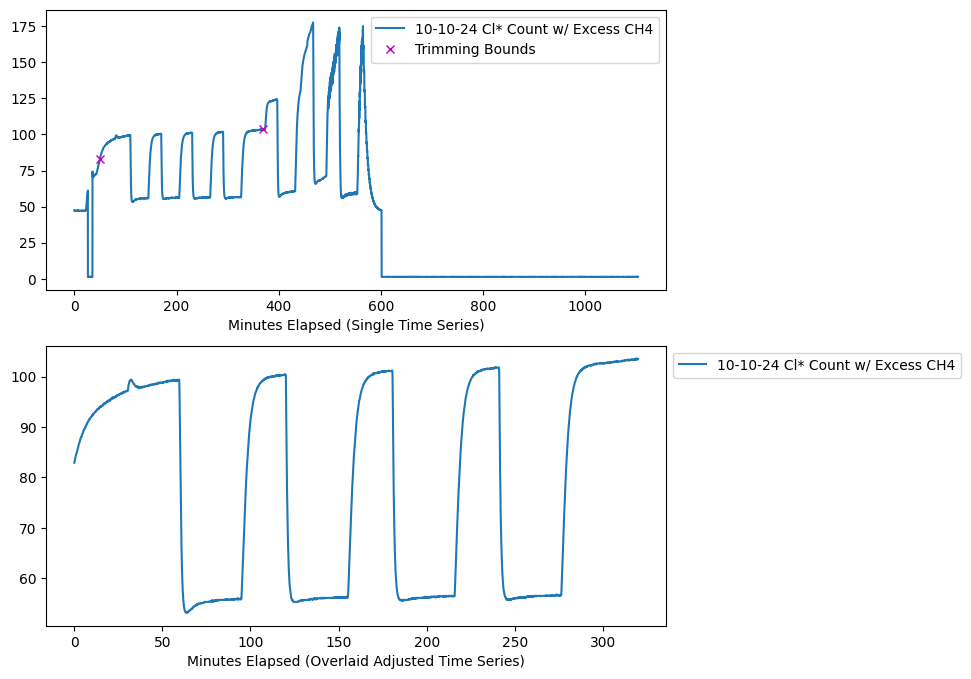

In [2]:
#@np.vectorize
def subtract_cl2_baseline(mv):# This baseline stays fixed within a given campaign but may change from campaign to campaign due to tweaking the Cl2 sensor setup
    return (mv-47.0)

importlib.reload(process_cl2)
trim_params=((50,370),
             )
(data,ax1,ax2) = process_cl2.trim_dataframes(raw_data,trim_params,
                                   plot=True,which_field='Cl2 LabJack: Cl2 Node A (mV)',which_df=0)
rf = process_cl2.RemovalFinder(data,"10-23_cl2_misc_follow_ups")

<h1> First attempt to count *Cl </h1>

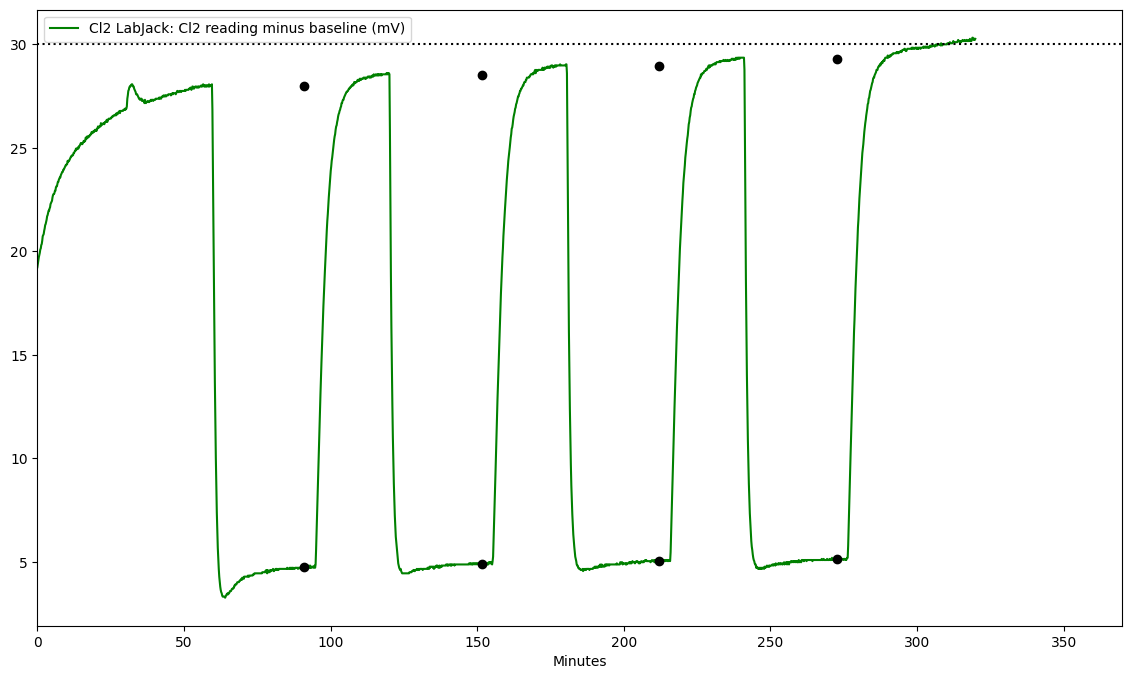

In [3]:
importlib.reload(process_cl2)
current_experiment = '10-10-24 Cl* Count w/ Excess CH4'
rf.dump_experiment(current_experiment)

# Force a different Cl2 calibration
def calibrate_cl2_special(mv):
    return (mv-47)*30/(103-47)#Seems like the baseline is around 47 these days.

data[current_experiment]['Cl2 LabJack: Cl2 reading minus baseline (mV)'] = calibrate_cl2_special(data[current_experiment]['Cl2 LabJack: Cl2 Node A (mV)'])
data[current_experiment]['Selected: CH4 (ppm)'] = data[current_experiment]['FTIR: CH4 (ppm)']


# Prep the plot region
(fig, axs) = plt.subplots(nrows=1,figsize=(14,8),sharex=True)
axs = [axs]

# Process the bypass periods
rf.set_tags('UV_distance_conv=50')
rf.isolate_bypass_periods(current_experiment)
# Process the Cl2
rf.set_setup_values(which_field='Cl2 LabJack: Cl2 reading minus baseline (mV)')
rf.autofind_removal(current_experiment,start_time=0,end_time=500,correct_drift=False)
rf.plot_baseline_and_samples(current_experiment,which_field='Cl2 LabJack: Cl2 reading minus baseline (mV)',color='g',marker='o',ax=axs[0],do_shading=False)
axs[0].legend()

#print(rf.translate_tags("UV_distance_conv=50; dummy='whatever'")['UV_distance_conv'])
axs[0].set_xlim(0,370)

axs[0].set_xlabel("Minutes")

axs[0].plot([0,450],[30,30],':k')#Help compare how much the Cl2 drifted between the initial and ending 30ppm trials -- no more than 10%!

pass


In [4]:
rf.export_conversion_results_to_csv('../_exported_data/')
rf.export_bypass_periods('../_exported_data/')